# Project 4: Amplitude damping

# Solution

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import json
import copy

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Error mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, 
                                                CompleteMeasFitter, 
                                                MeasurementFilter)

# Utility functions
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.jobstatus import JobStatus

In [2]:
# We use ibmq_vigo
IBMQ.load_account()
backend = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend('ibmq_quito')

# Local simulator and vector simulator
simulator = Aer.get_backend('qasm_simulator')

## Task 1

In [8]:
def c1(R,t):
    """Returns the coherence factor in the amplitude damping channel
    
    Args:
        R (float): value of R = \gamma_0/\lambda
        t (float): value of the time variable
    
    Returns:
        A float number
    """
    
    if R < 0.5:
        c1 = np.exp(- t / 2.0) * (np.cosh(t * np.sqrt(1.0 - 2.0 * R) / 2.0) + 1.0 / np.sqrt(1.0 - 2.0 * R) * np.sinh(t * np.sqrt(1.0 - 2.0 * R) / 2.0))
    else:
        c1 = np.exp(- t / 2.0) * (np.cos(t * np.sqrt(2.0 * R - 1.0) / 2.0) + 1.0 / np.sqrt(2.0 * R - 1.0) * np.sin(t * np.sqrt(2.0 * R - 1.0) / 2.0))
    
    return c1

### Task 2

In [9]:
def amplitude_damping_channel(q, c, sys, env, R, t):
    """Returns a QuantumCircuit implementing the amplitude damping channel on the system qubit
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        c (ClassicalRegister): the register to use for the measurement of the system qubit
        sys (int): index for the system qubit
        env (int): index for the environment qubit
        R (float): value of R = \gamma_0/\lambda
        t (float): value of the time variable
    
    Returns:
        A QuantumCircuit object
    """
    ad = QuantumCircuit(q, c)
    
    # Rotation angle
    theta = 2.0 * np.arccos(c1(R, t))
    
    # Channel
    ad.cu3(theta, 0.0, 0.0, q[sys], q[env])
    ad.cx(q[env], q[sys])
    
    # Masurement in the computational basis
    ad.measure(q[sys], c[0])
    
    return ad

# We choose to add the initial condition elsewhere
def initial_state(q, sys):
    """Returns a QuantumCircuit implementing the initial condition for the amplitude damping channel
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        sys (int): index for the system qubit
    
    Returns:
        A QuantumCircuit object
    """
    # Create circuit
    ic = QuantumCircuit(q)
    
    # System in |1>
    ic.x(q[sys])
    
    return ic

### Task 3

In [10]:
SHOTS = 8192

# The values for R and corresponding times
R_values = [0.2, 100.0, 200.0, 400.0]
npoints = 30
t_values = {}
for R in R_values:
    t_values[R] = np.linspace(0.0, 6.0 * np.pi / np.sqrt(abs(2.0 * R - 1.0)), npoints)

# We create the quantum circuits
q = QuantumRegister(5, name="q")
c = ClassicalRegister(1, name="c")

## Indices of the system and environment qubits
sys = 1
env = 2

## For values of R and thirty values of t for each
circuits = {}
for R in R_values:
    circuits[R] = []
    for t in t_values[R]:
        circuits[R].append(initial_state(q, sys)
                           +amplitude_damping_channel(q, c, sys, env, R, t))

<ipython-input-9-83ef246f7da2>:21: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  ad.cu3(theta, 0.0, 0.0, q[sys], q[env])
<ipython-input-10-0242ce512c11>:23: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuits[R].append(initial_state(q, sys)
/Users/matteo/Library/Caches/pypoetry/virtualenvs/oqs-jupyterbook-_Llz9vLR-py3.8/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


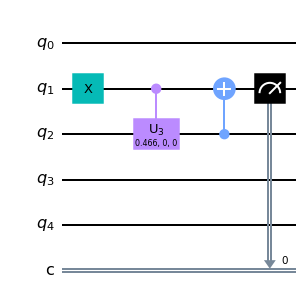

In [11]:
circuits[0.2][1].draw(output='mpl')

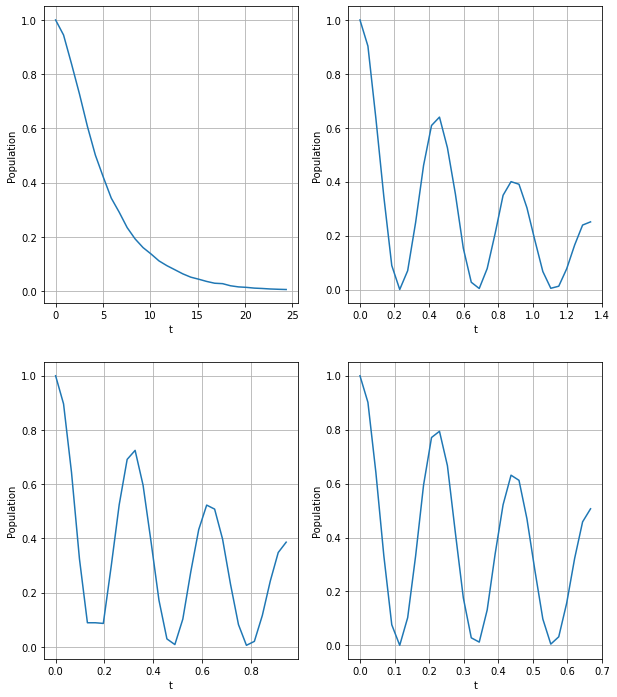

In [12]:
# Execute the circuits on the local simulator
jobs_sim = {}
for R in R_values:
    jobs_sim[R] = execute(circuits[R], backend = simulator, shots = SHOTS)

# Analyse the outcomes
populations_sim = {}
for R in R_values:
    populations_sim[R] = []
    current_job_res = jobs_sim[R].result()
    for i in range(npoints):
        counts = current_job_res.get_counts(i)
        if '1' in counts:
            sm = counts['1']/float(SHOTS)
        populations_sim[R].append(sm)

# Plot the results
fig_idx = 221
plt.figure(figsize=(10,12))
for R in R_values:
    plt.subplot(fig_idx)
    plt.plot(t_values[R], populations_sim[R])
    plt.xlabel('t')
    plt.ylabel('Population')
    fig_idx += 1
    plt.grid()

### Homework (without non-Markovianity witness)

In [ ]:
# Calibration circuits
cal_circuits, state_labels = complete_meas_cal([sys], q, c)
# Run the calibration job
calibration_job = execute(cal_circuits, backend, shots=SHOTS)

# Run the circuits and save the jobs
jobs = {}
for R in R_values:
    jobs[R] = execute(circuits[R], backend = backend, shots = SHOTS)

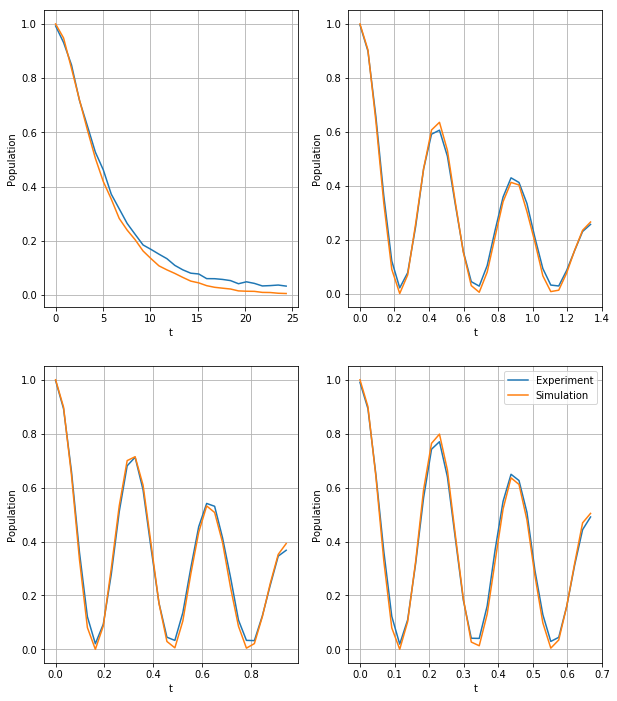

In [10]:
# Use the calibration job to implement the error mitigation
meas_fitter = CompleteMeasFitter(calibration_job.result(), state_labels)
meas_filter = meas_fitter.filter

# Analyse the outcomes
populations = {}
for R in jobs:
    populations[R] = []
    current_job_res = jobs[R].result()
    for i in range(npoints):
        counts = meas_filter.apply(current_job_res).get_counts(i)
        if '1' in counts:
            sm = counts['1']/float(SHOTS)
        populations[R].append(sm)

# Plot the results
fig_idx = 221
plt.figure(figsize=(10,12))
for R in R_values:
    plt.subplot(fig_idx)
    plt.plot(t_values[R], populations[R], label='Experiment')
    plt.plot(t_values[R], populations_sim[R], label='Simulation')
    plt.xlabel('t')
    plt.ylabel('Population')
    fig_idx += 1
    plt.grid()
plt.legend();

## Task 4

In [3]:
def amplitude_damping_channel_witness(q, c, sys, env, anc, observable, R, t):
    """Returns a QuantumCircuit implementing the amplitude damping channel on the system qubit with non-Markovianity witness
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        c (ClassicalRegister): the register to use for the measurement of the system and ancilla qubits
        sys (int): index for the system qubit
        env (int): index for the environment qubit
        anc (int): index for the ancillary qubit
        observable (str): the observable to be measured
        R (float): value of R = \gamma_0/\lambda
        t (float): value of the time variable
    
    Returns:
        A QuantumCircuit object
    """
    ad = QuantumCircuit(q, c)
    
    # Rotation angle
    theta = 2.0 * np.arccos(c1(R, t))
    
    # Channel
    ad.cu3(theta, 0.0, 0.0, q[sys], q[env])
    ad.cx(q[env], q[sys])
    
    # Masurement of the corresponding observable
    if observable == 'xx':
        ad.h(sys)
        ad.h(anc)
    elif observable == 'yy':
        ad.sdg(sys)
        ad.h(sys)
        ad.sdg(anc)
        ad.h(anc)
    ad.measure(sys,c[0])
    ad.measure(anc,c[1])
    
    return ad

# We set the initial entangled state separately
def initial_state_witness(q, sys, anc):
    """Returns a QuantumCircuit implementing the initial condition for the amplitude damping channel with non-Markovianity witness
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        sys (int): index for the system qubit
        anc (int): index for the ancilla qubit
    
    Returns:
        A QuantumCircuit object
    """
    # Create circuit
    ic = QuantumCircuit(q)
    
    # System and ancilla in |\psi^+>
    ic.h(q[sys])
    ic.cx(q[sys], q[anc])
    
    return ic

### Task 5

In [4]:
SHOTS = 8192

# The values for R and corresponding times,
# as well as the observables needed for the witness
observables = ['xx', 'yy', 'zz']
R_values = [0.2, 100.0]
npoints = 30
t_values = {}
for R in R_values:
    t_values[R] = np.linspace(0.0, 6.0 * np.pi / np.sqrt(abs(2.0 * R - 1.0)), npoints)

# We create the quantum circuits
q = QuantumRegister(5, name="q")
c = ClassicalRegister(2, name="c")

## Indices of the system, environment and ancillary qubits
sys = 1
env = 2
anc = 3

## Two values of R and thirty values of t for each
## The witness requires measuring three observables per point
circuits = {}
for R in R_values:
    circuits[R] = {}
    for observable in observables:
        circuits[R][observable] = []
        for t in t_values[R]:
            circuits[R][observable].append(initial_state_witness(q, sys, anc)
                               +amplitude_damping_channel_witness(q, c, sys, env, anc, observable, R, t))

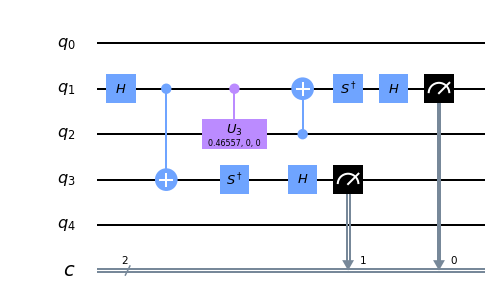

In [5]:
circuits[0.2]['yy'][1].draw(output='mpl')

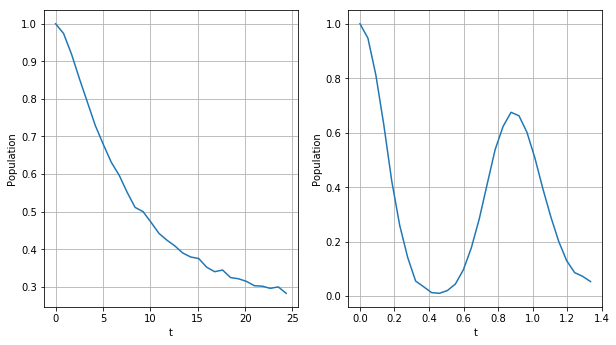

In [6]:
# Execute the circuits on the local simulator
jobs_sim = {}
for R in R_values:
    jobs_sim[R] = {}
    for observable in observables:
        jobs_sim[R][observable] = execute(circuits[R][observable], backend = simulator, shots = SHOTS)

# Analyse the outcomes
## Compute expected values
expected_sim = {}
for R in R_values:
    expected_sim[R] = {}
    for observable in observables:
        expected_sim[R][observable] = []
        current_job_res = jobs_sim[R][observable].result()
        for i in range(npoints):
            counts = current_job_res.get_counts(i)
            expc = 0.0
            for outcome in counts:
                if outcome[0] == outcome[1]:
                    expc += counts[outcome]/float(SHOTS)
                else:
                    expc -= counts[outcome]/float(SHOTS)
            expected_sim[R][observable].append(expc)

## Compute witness
witness_sim = {}
for R in R_values:
    witness_sim[R] = []
    for i in range(npoints):
        w = 0.25*(1.0+expected_sim[R]['xx'][i]-expected_sim[R]['yy'][i]+expected_sim[R]['zz'][i])
        witness_sim[R].append(w)

# Plot the results
fig_idx = 221
plt.figure(figsize=(10,12))
for R in R_values:
    plt.subplot(fig_idx)
    plt.plot(t_values[R], witness_sim[R])
    plt.xlabel('t')
    plt.ylabel('Population')
    fig_idx += 1
    plt.grid()

### Homework (implementation of non-Markovianity witness)

In [ ]:
# Calibration circuits
cal_circuits, state_labels = complete_meas_cal([sys, anc], q, c)
# Run the calibration job
calibration_job = execute(cal_circuits, backend, shots=SHOTS)

# Run the circuits and save the jobs
jobs = {}
for R in R_values:
    jobs[R] = {}
    for observable in observables:
        jobs[R][observable] = execute(circuits[R][observable], backend = backend, shots = SHOTS)

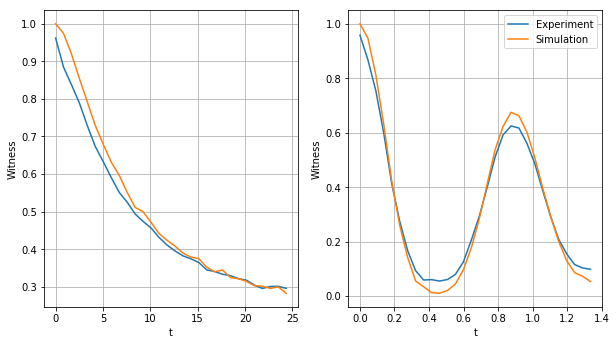

In [9]:
# Use the calibration job to implement the error mitigation
meas_fitter = CompleteMeasFitter(calibration_job.result(), state_labels)
meas_filter = meas_fitter.filter

# Analyse the outcomes
## Compute expected values
expected = {}
for R in R_values:
    expected[R] = {}
    for observable in observables:
        expected[R][observable] = []
        current_job_res = jobs[R][observable].result()
        mitigated_res = meas_filter.apply(current_job_res)
        for i in range(npoints):
            counts = mitigated_res.get_counts(i)
            expc = 0.0
            for outcome in counts:
                if outcome[0] == outcome[1]:
                    expc += counts[outcome]/float(SHOTS)
                else:
                    expc -= counts[outcome]/float(SHOTS)
            expected[R][observable].append(expc)

## Compute witness
witness = {}
for R in R_values:
    witness[R] = []
    for i in range(npoints):
        w = 0.25*(1.0+expected[R]['xx'][i]-expected[R]['yy'][i]+expected[R]['zz'][i])
        witness[R].append(w)

# Plot the results
fig_idx = 221
plt.figure(figsize=(10,12))
for R in R_values:
    plt.subplot(fig_idx)
    plt.plot(t_values[R], witness[R], label='Experiment')
    plt.plot(t_values[R], witness_sim[R], label='Simulation')
    plt.xlabel('t')
    plt.ylabel('Witness')
    fig_idx += 1
    plt.grid()
plt.legend();